In [2]:
import torch
from torch import nn
from torch.nn import functional as F

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

from matplotlib import gridspec

import numpy as np

import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from IPython import display

In [3]:
# 判断是否有GPU

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
"""
    加载数据
    - 模仿的对象
    - 真品
"""

# 加载并预处理图像
data = datasets.MNIST(root="data", 
                      train=True, 
                      transform = transforms.Compose(transforms=[transforms.ToTensor(),
                                                                transforms.Normalize(mean=[0.5], std=[0.5])]),
                      download=True)
# 封装成 DataLoader
data_loader = DataLoader(dataset=data, batch_size=100, shuffle=True)

In [5]:
for image, label in data_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100])


#### 核心的GAN思想

In [6]:
"""
    定义生成器
"""

class Generator(nn.Module):
    """
        定义一个图像生成
        输入：一个向量(随机噪声，随机数)
        输出：一个向量（代表图像，28 * 28）
    """
    def __init__(self, in_features=128, out_features=28 * 28):
        """
            挂载超参数
        """
        # 先初始化父类，再初始化子类
        super(Generator, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        
        # 第一个隐藏层
        self.hidden0 = nn.Linear(in_features=self.in_features, out_features=256)
        
        # 第二个隐藏层
        self.hidden1 = nn.Linear(in_features=256, out_features=512)
        
        # 第三个隐藏层
        self.hidden2 = nn.Linear(in_features=512, out_features=self.out_features)
    
    def forward(self, x):
        
        # 第一层 [b, 128] --> [b, 256]
        h = self.hidden0(x)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        
        # 第二层 [b, 256] --> [b, 512]
        h = self.hidden1(h)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        
        # 第三层 [b, 512] --> [b, 28 * 28]
        h = self.hidden2(h)
        
        # 压缩数据的变化范围
        o = torch.tanh(h)
        
        return o

In [6]:
28 * 28

784

In [7]:
"""
    定义一个鉴别器
"""

class Discriminator(nn.Module):
    """
        本质：二分类分类器
        输入：一个对象
        输出：真品还是赝品
    """
    def __init__(self, in_features=28*28, out_features=1):
        super(Discriminator, self).__init__()
        
        self.in_features=in_features
        self.out_features=out_features
        
        # 第一个隐藏层
        self.hidden0= nn.Linear(in_features=self.in_features, out_features=512)
        
        # 第二个隐藏层
        self.hidden1= nn.Linear(in_features=512, out_features=256)
        
        # 第三个隐藏层
        self.hidden2= nn.Linear(in_features=256, out_features=32)
        
        # 第四个隐藏层
        self.hidden3= nn.Linear(in_features=32, out_features=self.out_features)
        
    
    def forward(self, x):
        
        # 第一层
        h = self.hidden0(x)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        h = F.dropout(input=h, p=0.2)
        
        # 第二层
        h = self.hidden1(h)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        h = F.dropout(input=h, p=0.2)
        
        # 第三层
        h = self.hidden2(h)
        h = F.leaky_relu(input=h, negative_slope=0.2)
        h = F.dropout(input=h, p=0.2)
        
        # 第四层
        h = self.hidden3(h)
        
        # 输出概率
        o = torch.sigmoid(h)
        
        return o

In [8]:
"""
    构建模型
"""
# 定义一个生成器
generator = Generator(in_features=128, out_features=784)
generator.to(device=device)

# 定义一个鉴别器
discriminator = Discriminator(in_features=784, out_features=1)
discriminator.to(device=device)

Discriminator(
  (hidden0): Linear(in_features=784, out_features=512, bias=True)
  (hidden1): Linear(in_features=512, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=1, bias=True)
)

In [9]:
"""
    定义优化器
"""

# 定义一个生成器的优化器
g_optimizer = torch.optim.Adam(params=generator.parameters(), lr=1e-4)

# 定义一个鉴别的优化器
d_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=1e-4)

In [10]:
"""
    定义一个损失函数
"""
loss_fn = nn.BCELoss()

In [11]:
# 定义训练轮次
num_epochs = 1000

In [12]:
"""
    获取数据的标签
"""

def get_real_data_labels(size):
    """
        获取真实数据的标签（待模仿的数据）
        所有的真实数据标签都是1
    """
    labels = torch.ones(size, 1, device=device)
    
    return labels

def get_fake_data_labels(size):
    """
        获取虚假数据的标签（生成器生成的）
        所有的假数据，标签都是 0
    """
    labels = torch.zeros(size, 1, device=device)
    
    return labels

In [13]:
"""
    噪声生成器
"""
def get_noise(size):
    """
        给生成器准备数据
        - 128维度的向量
    """
    X = torch.randn(size, 128, device=device)
    
    return X

In [14]:
get_noise(16)

tensor([[ 1.5287,  0.0292, -0.3083,  ..., -0.3031,  0.7338,  0.4723],
        [-0.6448, -0.7657,  1.1840,  ...,  0.5558,  0.3207, -0.1947],
        [-0.6149,  0.6310, -1.4330,  ...,  0.2612,  1.6054,  0.3347],
        ...,
        [-0.6282,  0.0897, -0.3656,  ..., -0.6662,  0.8075,  1.1256],
        [-1.4849, -0.6184, -0.3626,  ...,  1.5252, -0.3384,  0.4660],
        [-0.9670, -0.1829, -0.0036,  ..., -0.4775, -0.4381, -0.4960]])

In [15]:
# 获取一批测试数据

num_test_samples = 16
test_noise = get_noise(num_test_samples)

In [16]:
test_noise

tensor([[-0.2594, -1.8688, -0.5124,  ..., -0.3810,  1.3185,  0.3974],
        [ 0.3121,  0.8754,  0.8958,  ...,  0.4748,  0.6733,  0.9003],
        [ 0.4279, -0.3498, -0.5662,  ..., -0.9037,  0.8012,  0.7511],
        ...,
        [-1.9091,  2.1905, -1.4140,  ..., -0.5929, -0.6040,  0.2143],
        [-1.7849, -1.1662, -0.8805,  ...,  1.4776,  0.8710, -0.4186],
        [ 1.0506,  0.6552,  0.7460,  ...,  0.2669,  0.8463,  0.3432]])

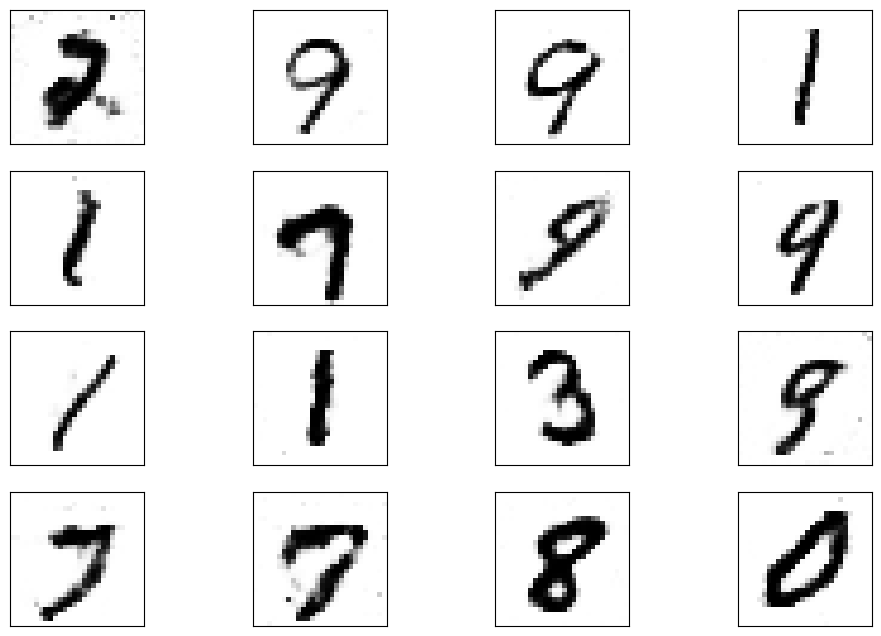

In [17]:
"""
    训练过程
"""

g_losses = []
d_losses = []

for epoch in range(1, num_epochs+1):
    
    print(f"当前正在进行 第 {epoch} 轮 ....")
    
    # 设置训练模式
    generator.train()
    discriminator.train()
    
    # 遍历真实的图像
    for batch_idx, (batch_real_data, _) in enumerate(data_loader):
        
               
        """
        1, 先训练鉴别器
            鉴别器就是一个二分类问题
            - 给一批真数据，输出真
            - 给一批假数据，输出假
        
        """
        
        # 1.1 准备数据
        # 图像转向量 [b, 1, 28, 28] ---> [b, 784]
        # 从数据集中获取100个真实的手写数字图像
        real_data = batch_real_data.view(batch_real_data.size(0), -1).to(device=device)
        
        # 噪声[b, 100]
        # 随机生成100个100维度的噪声，用于生成假图像
        noise = get_noise(real_data.size(0))
        
        # 根据噪声，生成假数据 
        # [b, 100] --> [b, 784]
        fake_data = generator(noise).detach()
                
        
        # 1.2 训练过程
        
        # 鉴别器的优化器梯度情况
        d_optimizer.zero_grad()
        
        # 对真实数据鉴别
        real_pred = discriminator(real_data)
        
        # 计算真实数据的误差
        real_loss = loss_fn(real_pred, get_real_data_labels(real_data.size(0)))
        
        # 真实数据的梯度回传
        real_loss.backward()

        
        # 对假数据鉴别
        fake_pred = discriminator(fake_data)
        
        # 计算假数据的误差
        fake_loss = loss_fn(fake_pred, get_fake_data_labels(fake_data.size(0)))
        
        # 假数据梯度回传
        fake_loss.backward()
        
        # 梯度更新
        d_optimizer.step()

        # ----------------
        
        d_losses.append((real_loss + fake_loss).item())
        
#         print(f"鉴别器的损失:{real_loss + fake_loss}")
        
        
        """2, 再训练生成器"""
        
        # 获取生成器的生成结果
        fake_pred = generator(get_noise(real_data.size(0)))
        
        # 生产器梯度清空
        g_optimizer.zero_grad()
        
        # 把假数据让鉴别器鉴别一下
        # 把discriminator requires_grad = False
        # 设置为不可学习
        for param in discriminator.parameters():
            param.requires_grad = False
            
        d_pred = discriminator(fake_pred)
        
        # 设置为可学习
        for param in discriminator.parameters():
            param.requires_grad = True
        
        # 计算损失
        # 把一个假东西，给专家看，专家说是真的，这个时候，造假的水平就可以了
        g_loss = loss_fn(d_pred, get_real_data_labels(d_pred.size(0)))
        
        # 梯度回传
        g_loss.backward()
        
        # 参数更新
        g_optimizer.step()
        
#         print(f"生成器误差：{g_loss}")
        g_losses.append(g_loss.item())
   
    # 每轮训练之后，观察生成器的效果
    generator.eval()
    
    with torch.no_grad():
        
        # 正向推理
        img_pred = generator(test_noise)
        img_pred = img_pred.view(img_pred.size(0), 28, 28).cpu().data
        
        # 画图
        display.clear_output(wait=True)
        
        # 设置画图的大小
        fig = plt.figure(1, figsize=(12, 8)) 
        # 划分为 4 x 4 的 网格
        gs = gridspec.GridSpec(4, 4)
        
        # 遍历每一个
        for i in range(4):
            for j in range(4):
                # 取每一个图
                X = img_pred[i * 4 + j, :, :]
                # 添加一个对应网格内的子图
                ax = fig.add_subplot(gs[i, j])
                # 在子图内绘制图像
                ax.matshow(X, cmap=plt.get_cmap("Greys"))
#                 ax.set_xlabel(f"{label}")
                ax.set_xticks(())
                ax.set_yticks(())
        plt.show()
 

In [18]:
generator

Generator(
  (hidden0): Linear(in_features=128, out_features=256, bias=True)
  (hidden1): Linear(in_features=256, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=784, bias=True)
)

In [19]:
get_noise(1)

tensor([[-1.2961e+00,  2.1338e+00,  3.0627e+00,  6.9977e-01,  3.5969e-01,
          1.2468e-01,  5.1510e-01, -8.5144e-01, -1.5063e+00, -2.2374e-01,
          1.9660e+00, -1.4693e+00,  1.0253e+00,  2.4812e-01,  1.0339e+00,
         -1.0534e+00,  3.8728e-01, -2.8982e-01, -1.4531e+00,  7.7362e-01,
         -8.4519e-01,  1.1455e+00,  1.0441e+00, -7.8484e-01,  7.6992e-01,
          2.6080e+00,  5.5941e-02, -3.6691e-04, -8.3243e-01,  1.3959e-01,
          9.6574e-01, -6.2679e-01,  4.7280e-02,  2.3896e+00,  7.9715e-01,
         -6.3444e-01, -7.2009e-02,  1.7510e+00,  1.5930e+00,  3.1718e+00,
          4.8139e-01,  3.4657e-01, -1.5162e+00,  7.4824e-01,  1.6362e+00,
          8.4625e-01,  2.7518e-01, -3.8411e-01,  7.1633e-01,  2.8520e-01,
          1.4339e-01, -1.4160e-01,  2.1755e-01, -1.0147e+00,  3.3311e-01,
          7.0503e-01,  1.4490e-01,  7.8702e-01,  9.3564e-01, -5.8967e-02,
          1.6150e+00,  1.2677e+00, -1.2517e+00, -9.0832e-02, -8.3042e-01,
         -6.8203e-01,  3.1575e-01, -7.

In [20]:
img = generator(get_noise(1)).detach()

In [21]:
img

tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9983, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -0.9745, -0.9810, -0.8726, -0.9980, -0.9995, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -

In [22]:
img1 = ((img * 0.5 + 0.5) * 255).cpu().numpy().astype(int).reshape(28, 28)

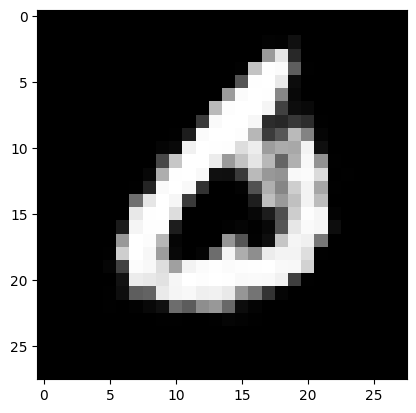

In [23]:
plt.imshow(X=img1, cmap="gray")

In [24]:
def generate_fake_img():
    with torch.no_grad():
        noise = torch.randn(1, 128).cuda()
        img = generator(noise)
        img = ((img * 0.5 + 0.5) * 255).cpu().numpy().astype(int).reshape(28, 28)
        plt.imshow(X=img, cmap="gray")
        

In [25]:
generate_fake_img()

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# prompts